/Users/jonasmucke/miniconda3/lib/python3.10/site-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: [18 19 22 23 24 25 28 29 38 39 48 49 68 69]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


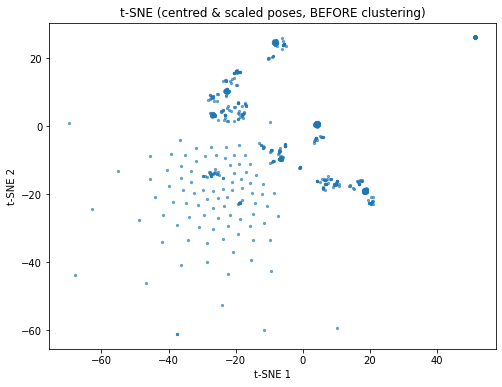

/Users/jonasmucke/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jonasmucke/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jonasmucke/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jonasmucke/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_

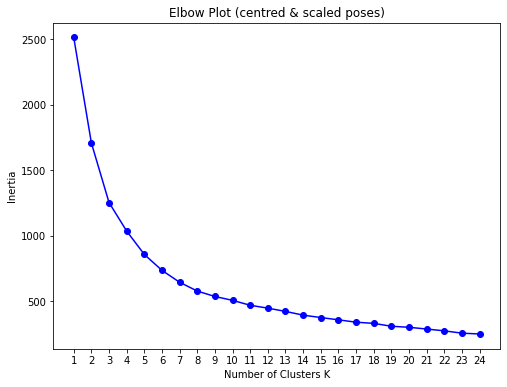

/Users/jonasmucke/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/q8/3qtld8c51tq6rsc2lwvp417w0000gn/T/ipykernel_96837/37340489.py:92: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", chosen_k)


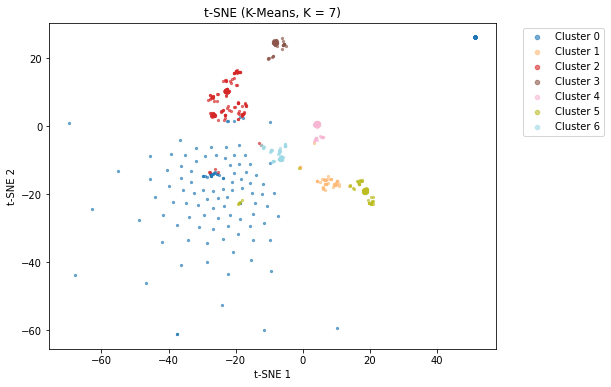


Train size: 675
cluster
0    0.536296
1    0.066667
2    0.164444
3    0.050370
4    0.045926
5    0.075556
6    0.060741
Name: proportion, dtype: float64

Val size: 84
cluster
0    0.535714
1    0.059524
2    0.166667
3    0.059524
4    0.047619
5    0.071429
6    0.059524
Name: proportion, dtype: float64

Test size: 85
cluster
0    0.541176
1    0.070588
2    0.164706
3    0.047059
4    0.035294
5    0.082353
6    0.058824
Name: proportion, dtype: float64


In [9]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Load the annotations file (change path if needed)
df = pd.read_csv("Rat/top/annotations.csv")

# -----------------------------------------------------------
# 1a.  Drop filename + bbox columns  -------------------------
# -----------------------------------------------------------
drop_cols = []
if "filename" in df.columns:
    drop_cols.append("filename")
for col in df.columns:
    if col.startswith("bbox_"):
        drop_cols.append(col)

df_filtered = df.drop(columns=drop_cols)

# -----------------------------------------------------------
# 2.  Translation / scale normalisation  --------------------
# -----------------------------------------------------------
# A) reference joint for centering:  back_midpoint
root_x = df_filtered["back_midpoint-x"]
root_y = df_filtered["back_midpoint-y"]

centered = df_filtered.copy()
for col in df_filtered.columns:
    if col.endswith("-x"):
        centered[col] = df_filtered[col] - root_x
    elif col.endswith("-y"):
        centered[col] = df_filtered[col] - root_y

# B) per-frame scale: distance head_midpoint ↔ tail_base
dx = df_filtered["head_midpoint-x"] - df_filtered["tail_base-x"]
dy = df_filtered["head_midpoint-y"] - df_filtered["tail_base-y"]
body_len = np.sqrt(dx**2 + dy**2).replace(0, 1.0)   # avoid divide-by-0

scaled = centered.div(body_len, axis=0)

# -----------------------------------------------------------
# 3.  Impute missing values  --------------------------------
# -----------------------------------------------------------
X_raw = scaled.values
X = SimpleImputer(strategy="mean").fit_transform(X_raw)

# -----------------------------------------------------------
# 4.  t-SNE BEFORE clustering  ------------------------------
# -----------------------------------------------------------
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=5, alpha=0.6)
plt.title("t-SNE (centred & scaled poses, BEFORE clustering)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

# -----------------------------------------------------------
# 5.  Elbow method  -----------------------------------------
# -----------------------------------------------------------
inertias = []
K_range = range(1, 25)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(K_range, inertias, "bo-")
plt.xticks(K_range)
plt.xlabel("Number of Clusters K")
plt.ylabel("Inertia")
plt.title("Elbow Plot (centred & scaled poses)")
plt.show()

# -----------------------------------------------------------
# 6.  Choose K and fit K-Means  ------------------------------
# -----------------------------------------------------------
chosen_k = 7          # <-- change after eyeballing elbow plot
kmeans = KMeans(n_clusters=chosen_k, random_state=42)
cluster_labels = kmeans.fit_predict(X)
df["cluster"] = cluster_labels          # keep labels in original df

# 7.  t-SNE AFTER clustering
plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap("tab20", chosen_k)
for lbl in range(chosen_k):
    mask = cluster_labels == lbl
    plt.scatter(
        X_tsne[mask, 0],
        X_tsne[mask, 1],
        s=5,
        alpha=0.6,
        color=colors(lbl),
        label=f"Cluster {lbl}",
    )
plt.title(f"t-SNE (K-Means, K = {chosen_k})")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

# -----------------------------------------------------------
# 8.  Stratified 80/10/10 split  ----------------------------
# -----------------------------------------------------------
idx = np.arange(len(df))
train_idx, temp_idx, y_train, y_temp = train_test_split(
    idx, df["cluster"], test_size=0.2, stratify=df["cluster"], random_state=42
)
val_idx, test_idx, _, _ = train_test_split(
    temp_idx, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

train_df = df.iloc[train_idx].reset_index(drop=True)
val_df   = df.iloc[val_idx].reset_index(drop=True)
test_df  = df.iloc[test_idx].reset_index(drop=True)

print("\nTrain size:", len(train_df))
print(train_df["cluster"].value_counts(normalize=True).sort_index())
print("\nVal size:", len(val_df))
print(val_df["cluster"].value_counts(normalize=True).sort_index())
print("\nTest size:", len(test_df))
print(test_df["cluster"].value_counts(normalize=True).sort_index())

# 9.  Save splits
train_df.to_csv("Rat/top/train_annotations.csv", index=False)
val_df.to_csv("Rat/top/val_annotations.csv",   index=False)
test_df.to_csv("Rat/top/test_annotations.csv", index=False)


/Users/jonasmucke/Desktop/pose_estimation/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jonasmucke/Desktop/pose_estimation/venv/lib/python3.10/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['back_right_wrist-x' 'back_right_wrist-y' 'chest-x' 'chest-y'
 'front_left_elbow-x' 'front_left_elbow-y' 'front_left_shoulder-x'
 'front_left_shoulder-y' 'front_right_wrist-x' 'front_right_wrist-y'
 'lower_jaw-x' 'lower_jaw-y' 'throat-x' 'throat-y'
 'dist_front_left_paw_front_right_paw'
 'dist_front_left_paw_back_right_paw'
 'dist_front_right_paw_back_right_paw' 'dist_back_left_paw_back_right_paw']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/jonasmucke/Desktop/pose_estimation/venv/lib/pyth

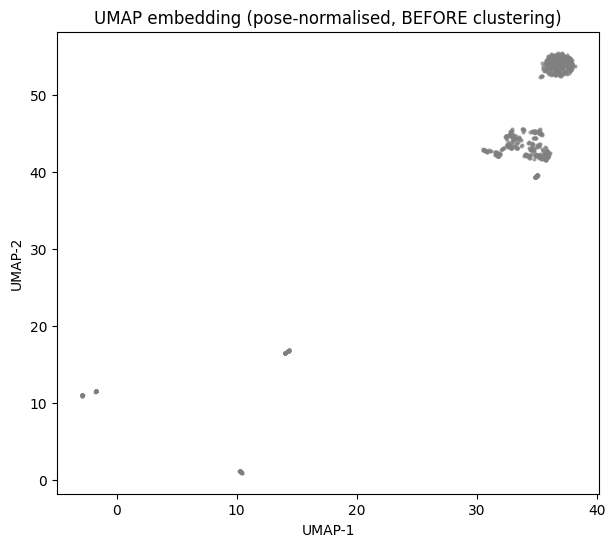

/Users/jonasmucke/Desktop/pose_estimation/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonasmucke/Desktop/pose_estimation/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/q8/3qtld8c51tq6rsc2lwvp417w0000gn/T/ipykernel_92679/2196720341.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(unique))


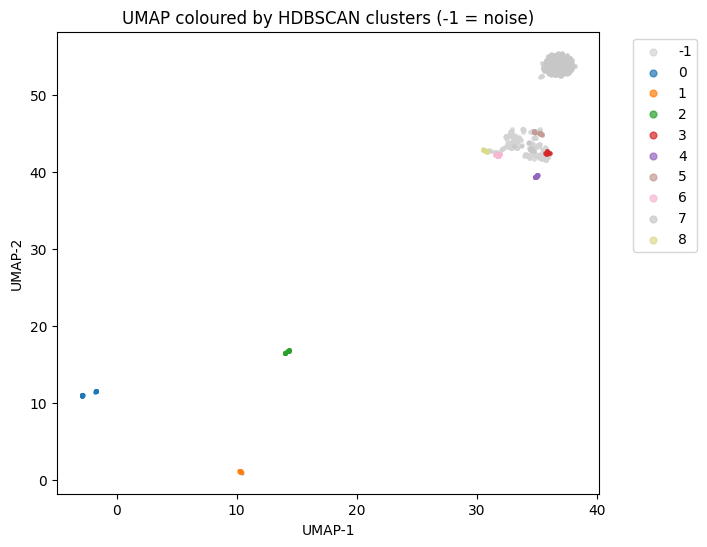


Train size: 675
cluster_hdb
-1    0.281481
 0    0.029630
 1    0.026667
 2    0.026667
 3    0.011852
 4    0.028148
 5    0.026667
 6    0.023704
 7    0.522963
 8    0.022222
Name: proportion, dtype: float64

Val size: 84
cluster_hdb
-1    0.273810
 0    0.035714
 1    0.023810
 2    0.035714
 3    0.011905
 4    0.023810
 5    0.023810
 6    0.023810
 7    0.523810
 8    0.023810
Name: proportion, dtype: float64

Test size: 85
cluster_hdb
-1    0.282353
 0    0.023529
 1    0.023529
 2    0.023529
 3    0.011765
 4    0.035294
 5    0.023529
 6    0.023529
 7    0.529412
 8    0.023529
Name: proportion, dtype: float64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import umap
from umap import UMAP
import hdbscan

# ------------------------------------------------------------------
# 1  Load CSV and drop non-pose columns
# ------------------------------------------------------------------
df = pd.read_csv("Rat/top/annotations.csv")

drop_cols = []
if "filename" in df.columns:
    drop_cols.append("filename")
drop_cols += [c for c in df.columns if c.startswith("bbox_")]
pose_df = df.drop(columns=drop_cols)

# ------------------------------------------------------------------
# 2  Translation (centre on back_midpoint)
# ------------------------------------------------------------------
root_x = pose_df["back_midpoint-x"]
root_y = pose_df["back_midpoint-y"]

centred = pose_df.copy()
for col in pose_df.columns:
    if col.endswith("-x"):
        centred[col] = pose_df[col] - root_x
    elif col.endswith("-y"):
        centred[col] = pose_df[col] - root_y

# ------------------------------------------------------------------
# 3  Scale (divide by body length)
# ------------------------------------------------------------------
dx = pose_df["head_midpoint-x"] - pose_df["tail_base-x"]
dy = pose_df["head_midpoint-y"] - pose_df["tail_base-y"]
body_len = np.sqrt(dx**2 + dy**2).replace(0, 1.0)

scaled = centred.div(body_len, axis=0)

# ------------------------------------------------------------------
# 4  Rotation (align tail→head to +X axis)
# ------------------------------------------------------------------
tx = pose_df["tail_base-x"] - root_x
ty = pose_df["tail_base-y"] - root_y
hx = pose_df["head_midpoint-x"] - root_x
hy = pose_df["head_midpoint-y"] - root_y
axis_dx = hx - tx
axis_dy = hy - ty
theta = -np.arctan2(axis_dy, axis_dx)        # negative to rotate into +X

rotated = scaled.copy()
cos_t = np.cos(theta)
sin_t = np.sin(theta)

for kp in [c[:-2] for c in scaled.columns if c.endswith("-x")]:
    x_col, y_col = f"{kp}-x", f"{kp}-y"
    x = scaled[x_col]
    y = scaled[y_col]
    # rotate (x,y) by theta:  x' =  x*cosθ - y*sinθ,  y' = x*sinθ + y*cosθ
    rotated[x_col] = x * cos_t - y * sin_t
    rotated[y_col] = x * sin_t + y * cos_t

# ------------------------------------------------------------------
# 5  Build feature vector
#     • all rotated coords
#     • pairwise distances of 8 anchor joints
# ------------------------------------------------------------------
anchor_joints = [
    "head_midpoint", "back_midpoint", "tail_base", "tail_end",
    "front_left_paw", "front_right_paw", "back_left_paw", "back_right_paw",
]
dist_features = {}
for i, ji in enumerate(anchor_joints):
    for jj in anchor_joints[i + 1 :]:
        dx = rotated[f"{ji}-x"] - rotated[f"{jj}-x"]
        dy = rotated[f"{ji}-y"] - rotated[f"{jj}-y"]
        dist_features[f"dist_{ji}_{jj}"] = np.sqrt(dx**2 + dy**2)

dist_df = pd.DataFrame(dist_features)

# Concatenate coords + distances
feat_df = pd.concat([rotated, dist_df], axis=1)

# ------------------------------------------------------------------
# 6  Impute NaNs  →  Standardise
# ------------------------------------------------------------------
X = SimpleImputer(strategy="mean").fit_transform(feat_df)
X = StandardScaler().fit_transform(X)

# ------------------------------------------------------------------
# 7  UMAP 2-D embedding
# ------------------------------------------------------------------
umap = UMAP(n_neighbors=50, min_dist=0.4, random_state=42)
X_umap = umap.fit_transform(X)

plt.figure(figsize=(7, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=4, alpha=0.6, color="gray")
plt.title("UMAP embedding (pose-normalised, BEFORE clustering)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

# ------------------------------------------------------------------
# 8  HDBSCAN clustering
# ------------------------------------------------------------------
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, cluster_selection_epsilon=0.0)
labels = clusterer.fit_predict(X)      # -1 = noise
df["cluster_hdb"] = labels

# Visualise clusters in UMAP
unique = np.unique(labels)
cmap = plt.cm.get_cmap("tab20", len(unique))
plt.figure(figsize=(7, 6))
for lbl in unique:
    pts = labels == lbl
    col = "lightgray" if lbl == -1 else cmap(int(lbl) % 20)
    plt.scatter(X_umap[pts, 0], X_umap[pts, 1], s=6, alpha=0.7, color=col, label=f"{lbl}")
plt.title("UMAP coloured by HDBSCAN clusters (-1 = noise)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

# ------------------------------------------------------------------
# 9  80/10/10 split (stratify on HDBSCAN labels)
# ------------------------------------------------------------------
idx = np.arange(len(df))
train_idx, temp_idx, y_train, y_temp = train_test_split(
    idx, labels, test_size=0.2, stratify=labels, random_state=42
)
val_idx, test_idx, _, _ = train_test_split(
    temp_idx, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

train_df = df.iloc[train_idx].reset_index(drop=True)
val_df   = df.iloc[val_idx].reset_index(drop=True)
test_df  = df.iloc[test_idx].reset_index(drop=True)

print("\nTrain size:", len(train_df))
print(train_df["cluster_hdb"].value_counts(normalize=True, dropna=False).sort_index())
print("\nVal size:", len(val_df))
print(val_df["cluster_hdb"].value_counts(normalize=True, dropna=False).sort_index())
print("\nTest size:", len(test_df))
print(test_df["cluster_hdb"].value_counts(normalize=True, dropna=False).sort_index())

# ------------------------------------------------------------------
# 10  Save splits
# ------------------------------------------------------------------
#train_df.to_csv("Rat/top/train_annotations_hdb.csv", index=False)
#val_df.to_csv("Rat/top/val_annotations_hdb.csv", index=False)
#test_df.to_csv("Rat/top/test_annotations_hdb.csv", index=False)
df.to_csv("Rat/top/annotations_cluster_hdbscan.csv", index=False)



In [10]:
# … after dropping bbox + filename, imputing, etc. …
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)
df['tsne1'] = X_tsne[:, 0]
df['tsne2'] = X_tsne[:, 1]

chosen_k = 10
cluster_labels = KMeans(n_clusters=chosen_k, random_state=42).fit_predict(X)
df['cluster'] = cluster_labels

df.to_csv('Rat/top/annotations_with_clusters2.csv', index=False)


/Users/jonasmucke/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [7]:
# Make directories train test val
# Fill directories with frames from images folder based on test_annotations.csv, train_annotations.csv, val_annotations.csv
# First line in these files is 'filename'
import os
import shutil
import pandas as pd

# === Configurable Paths ===
# Folder containing your image frames
image_src_folder = "Rat/top/images"  # ← change this to where your images actually are

# Folder where you want to place split subfolders
dest_base = "Rat/top/"   # ← will create train/, val/, test/ under here

# CSV files for each split
csv_files = {
    "train": "Rat/top/train_annotations.csv",
    "val":   "Rat/top/val_annotations.csv",
    "test":  "Rat/top/test_annotations.csv",
}

# === Create directories ===
for split in csv_files:
    split_dir = os.path.join(dest_base, split)
    os.makedirs(split_dir, exist_ok=True)

# === Copy images into their respective split folders ===
for split, csv_file in csv_files.items():
    df = pd.read_csv(csv_file)
    if "filename" not in df.columns:
        raise KeyError(f"'filename' column not found in {csv_file}")
    for fname in df["filename"]:
        src_path = os.path.join(image_src_folder, fname)
        dst_path = os.path.join(dest_base, split, os.path.basename(fname))
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)
        else:
            print(f"Warning: Source file not found: {src_path}")

print("Done! Images have been copied into:")
for split in csv_files:
    print(f"  • {os.path.join(dest_base, split)}")


Done! Images have been copied into:
  • Rat/top/train
  • Rat/top/val
  • Rat/top/test


In [8]:
import pandas as pd

def find_always_empty_columns(csv_path):
    df = pd.read_csv(csv_path)
    # Drop non-keypoint or helper columns if you want, e.g. bbox_*
    # df = df.drop(columns=[c for c in df.columns if c.startswith('bbox_')], errors='ignore')

    # Find columns where every value is NaN
    always_empty = [col for col in df.columns if df[col].isna().all()]

    print(f"Always empty columns ({len(always_empty)}):")
    for col in always_empty:
        print("  ", col)

if __name__ == "__main__":
    find_always_empty_columns("Rat/top/annotations.csv")


Always empty columns (6):
   chest-x
   chest-y
   front_left_elbow-x
   front_left_elbow-y
   front_left_shoulder-x
   front_left_shoulder-y


In [13]:
import pandas as pd

def show_non_nan_entries(csv_path, column_name):
    # Load the annotations
    df = pd.read_csv(csv_path)

    # Verify the column exists
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found.")
        return

    # Select non-NaN entries and reset index so they’re numbered 1…N
    non_nan = df[column_name].dropna().reset_index(drop=True)

    if non_nan.empty:
        print(f"No non-NaN entries found in '{column_name}'.")
    else:
        print(f"Non-NaN entries in '{column_name}':")
        for idx, val in non_nan.items():
            # idx goes 0,1,2… so add 1 for human-friendly numbering
            print(f"{idx+1:>3}: {val}")


if __name__ == "__main__":
    csv_path = "Rat/top/annotations.csv"
    column = "front_right_shoulder-x"  # change to the column you want
    show_non_nan_entries(csv_path, column)


Non-NaN entries in 'front_right_shoulder-x':
  1: 1396.33
  2: 1152.25
  3: 1377.08
  4: 1371.55
  5: 1374.26
  6: 1381.92
  7: 592.21
  8: 1374.78
  9: 1221.87
 10: 617.48
 11: 1383.07
 12: 1149.76
 13: 1388.56
 14: 1383.07
 15: 1351.55
 16: 1383.07
 17: 1382.9
 18: 1037.65
 19: 1117.55
 20: 1037.66
 21: 1349.17


In [ ]:
# %% [markdown]
"""
# Reorder Keypoints Notebook

This notebook:
1. Loads a CSV of keypoint annotations
2. Reorders columns so that all `*-x` columns come first (in base-keypoint order),
   followed by all `*-y` columns in the same order
3. Keeps any `bbox_` columns at the end, without including them in the coordinate reordering
4. Displays a preview and saves the reordered CSV
"""

# %%
import pandas as pd

# %% [markdown]
"""
## 1. Define the reorder function
"""
# %%
def reorder_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Reorders a DataFrame so that:
      1. All non-bbox '-x' columns come first (in original base-name order)
      2. Then all non-bbox '-y' columns in the same order
      3. Finally, any 'bbox_' columns in their original order
    All other columns (e.g., filenames, metadata) remain at the front.
    """
    # Identify bbox columns (to exclude from coordinate reordering)
    bbox_cols = [c for c in df.columns if c.startswith('bbox_')]

    # Identify coordinate columns excluding bbox ones
    coord_cols = [c for c in df.columns 
                  if (c.endswith('-x') or c.endswith('-y'))
                  and not c.startswith('bbox_')]

    # Extract unique base names in the order they appear among coord_cols
    bases = []
    for c in coord_cols:
        base = c[:-2]  # strip off '-x' or '-y'
        if base not in bases:
            bases.append(base)

    # Build sorted x- and y-column lists for keypoints
    x_cols = [f"{b}-x" for b in bases if f"{b}-x" in df.columns]
    y_cols = [f"{b}-y" for b in bases if f"{b}-y" in df.columns]

    # Any other non-coordinate, non-bbox columns come first
    other_cols = [c for c in df.columns if c not in coord_cols + bbox_cols]

    # Final column ordering: others, x's, y's, then bbox columns
    new_order = other_cols + x_cols + y_cols + bbox_cols
    return df[new_order]

# %% [markdown]
"""
## 2. Load your CSV
Replace `'annotations.csv'` with your file path.
"""
# %%
input_csv = '/Users/jonasmucke/Desktop/pose_estimation/Rat/side/annotations.csv'  # <-- change as needed
print(f"Loading {input_csv}...")
df = pd.read_csv(input_csv)
print(f"Original columns ({len(df.columns)}): {df.columns.tolist()}")

# %% [markdown]
"""
## 3. Reorder and preview
"""
# %%
df_reordered = reorder_dataframe(df)
print(f"Reordered columns ({len(df_reordered.columns)}): {df_reordered.columns.tolist()}")

df_reordered.head()

# %% [markdown]
"""
## 4. Save the reordered CSV
"""
# %%
output_csv = input_csv + 'reordered_'
print(f"Saving to {output_csv}...")
df_reordered.to_csv(output_csv, index=False)
print("Done.")


Loading /Users/jonasmucke/Desktop/pose_estimation/Rat/top/annotations_test.csv...
Original columns (75): ['filename', 'back_croup-x', 'back_croup-y', 'back_left_hip-x', 'back_left_hip-y', 'back_left_knee-x', 'back_left_knee-y', 'back_left_paw-x', 'back_left_paw-y', 'back_left_wrist-x', 'back_left_wrist-y', 'back_midpoint-x', 'back_midpoint-y', 'back_right_hip-x', 'back_right_hip-y', 'back_right_knee-x', 'back_right_knee-y', 'back_right_paw-x', 'back_right_paw-y', 'back_right_wrist-x', 'back_right_wrist-y', 'back_withers-x', 'back_withers-y', 'chest-x', 'chest-y', 'front_left_elbow-x', 'front_left_elbow-y', 'front_left_paw-x', 'front_left_paw-y', 'front_left_shoulder-x', 'front_left_shoulder-y', 'front_left_wrist-x', 'front_left_wrist-y', 'front_right_elbow-x', 'front_right_elbow-y', 'front_right_paw-x', 'front_right_paw-y', 'front_right_shoulder-x', 'front_right_shoulder-y', 'front_right_wrist-x', 'front_right_wrist-y', 'head_midpoint-x', 'head_midpoint-y', 'left_ear_base-x', 'left_ear

## Merge annotations

In [21]:
import pandas as pd

csv1 = pd.read_csv('/Users/jonasmucke/Desktop/Jonas/datasets/Top1k_copy/annotations.csv')
csv2 = pd.read_csv('/Users/jonasmucke/Desktop/pose_estimation/Rat/top/annotations_tes.csv')


# rename top mouse annotations columns
csv1 = csv1.rename(columns={"tail_lower_midpont-x": "tail_lower_midpoint-x", "tail_upper_midpont-x": "tail_upper_midpoint-x", "tail_lower_midpont-y": "tail_lower_midpoint-y", "tail_upper_midpont-y": "tail_upper_midpoint-y"})

# drop ears_midpoint column
csv1 = csv1.drop(columns=['ears_midpoint-y', 'ears_midpoint-x'])

In [22]:
csv1

,filename,back_croup-x,back_midpoint-x,back_withers-x,left_ear_base-x,left_ear_tip-x,nose-x,right_ear_base-x,right_ear_tip-x,tail_base-x,...,right_ear_tip-y,tail_base-y,tail_end-y,tail_lower_midpoint-y,tail_midpoint-y,tail_upper_midpoint-y,bbox_tl-x,bbox_tl-y,bbox_br-x,bbox_br-y
0,20241126-171624-405220_2-1100.png,888.53,926.30,943.19,916.49,910.46,938.87,969.06,977.58,798.62,...,390.77,565.29,462.87,417.26,468.08,527.72,631.90,331.00,997.20,643.90
1,20241126-171624-405220_2-12.png,1003.33,1071.89,1137.55,1169.38,1179.78,1223.63,1173.69,1191.13,939.39,...,401.33,420.26,682.94,599.61,538.44,459.33,866.40,308.30,1225.60,684.80
2,20241126-171624-405220_2-1239.png,863.19,916.58,972.82,1024.04,1037.35,1073.49,993.96,989.70,814.72,...,888.15,695.93,459.86,474.48,533.59,612.79,794.00,455.10,1077.50,900.20
3,20241126-171624-405220_2-129.png,1181.27,1210.58,1245.63,1310.93,1311.95,1372.46,1249.79,1221.14,1146.09,...,797.17,597.00,318.90,388.95,455.25,528.70,1022.80,318.40,1375.50,885.90
4,20241126-171624-405220_2-1316.png,1084.18,1108.01,1113.54,1080.61,1067.64,1072.77,1129.25,1139.24,1015.76,...,607.76,811.04,841.06,863.07,857.64,838.48,726.27,540.70,1168.90,867.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,20250315-145934-413966_2-435.png,1059.50,1012.66,962.41,899.20,905.02,875.12,946.02,961.87,1104.39,...,254.97,307.27,479.06,411.78,365.74,325.52,852.11,178.18,1294.34,486.63
1016,20250315-145934-413966_2-4820.png,1090.24,1036.23,989.20,939.87,932.69,896.35,950.15,948.37,1132.59,...,607.39,604.54,413.36,433.53,472.55,535.81,890.52,408.00,1166.05,723.03
1017,20250315-145934-413966_2-4941.png,1102.68,1051.35,995.66,949.62,943.64,896.85,953.03,950.96,1132.18,...,609.99,598.18,409.10,423.54,471.87,538.00,890.75,402.72,1166.66,719.12
1018,20250315-145934-413966_2-5118.png,1106.76,1059.50,1032.62,1002.64,991.30,1039.87,1044.03,1053.96,1159.15,...,549.25,652.87,419.93,479.18,553.52,619.59,967.60,413.44,1249.84,725.61


In [25]:
csv2

,filename,back_croup-x,back_left_hip-x,back_left_knee-x,back_left_paw-x,back_left_wrist-x,back_midpoint-x,back_right_hip-x,back_right_knee-x,back_right_paw-x,...,tail_base-y,tail_end-y,tail_lower_midpoint-y,tail_midpoint-y,tail_upper_midpoint-y,throat-y,bbox_tl-x,bbox_tl-y,bbox_br-x,bbox_br-y
0,images_R13_20240924_M100_2_V01_F1725.jpg,555.02,NaN,NaN,NaN,NaN,523.72,NaN,NaN,NaN,...,250.62,NaN,249.80,276.77,277.70,NaN,432.40,99.00,606.85,290.50
1,images_R17_20241118_M140_2_V01_F1232.jpg,1378.83,1426.33,NaN,NaN,NaN,1449.81,1358.42,NaN,NaN,...,NaN,479.08,NaN,NaN,NaN,NaN,1203.10,375.42,1496.50,627.50
2,images_R13_20240924_M150_2_V01_F1364.jpg,346.66,NaN,NaN,NaN,NaN,355.48,NaN,NaN,413.12,...,NaN,215.54,243.79,269.19,307.67,NaN,277.60,211.10,433.20,483.90
3,images_R12_20240924_M30_2_V01_F1508.jpg,469.79,NaN,NaN,NaN,NaN,468.38,425.48,425.04,NaN,...,487.94,531.34,479.29,439.96,443.53,NaN,406.62,422.92,629.65,671.36
4,images_R12_20240924_M100_2_V01_F0574.jpg,938.41,NaN,NaN,NaN,NaN,922.01,NaN,NaN,NaN,...,341.52,435.83,460.65,438.06,393.91,NaN,819.86,197.40,973.90,464.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,images_R12_20240924_M100_2_V01_F0502.jpg,937.42,NaN,NaN,NaN,NaN,926.57,NaN,NaN,NaN,...,340.53,423.93,454.13,433.63,390.97,NaN,822.10,197.90,972.40,462.40
840,images_R13_20240924_M100_2_V01_F0072.jpg,560.35,NaN,NaN,NaN,NaN,534.60,NaN,NaN,NaN,...,252.57,NaN,237.65,269.50,280.91,NaN,427.08,101.70,606.12,290.70
841,images_R17_20241118_M130_2_V01_F0434.jpg,1122.80,NaN,NaN,NaN,NaN,1160.13,NaN,NaN,NaN,...,NaN,885.48,NaN,NaN,NaN,NaN,984.70,805.20,1306.90,1016.80
842,images_R12_20240924_M140_2_V01_F1723.jpg,479.59,NaN,NaN,NaN,NaN,507.23,NaN,NaN,NaN,...,543.89,383.29,421.39,461.67,496.85,NaN,455.37,377.42,612.01,701.69


In [27]:
# merge annotations, keep columns of csv2 

merged = pd.concat([csv2, csv1], ignore_index=True)

merged


,filename,back_croup-x,back_left_hip-x,back_left_knee-x,back_left_paw-x,back_left_wrist-x,back_midpoint-x,back_right_hip-x,back_right_knee-x,back_right_paw-x,...,tail_base-y,tail_end-y,tail_lower_midpoint-y,tail_midpoint-y,tail_upper_midpoint-y,throat-y,bbox_tl-x,bbox_tl-y,bbox_br-x,bbox_br-y
0,images_R13_20240924_M100_2_V01_F1725.jpg,555.02,NaN,NaN,NaN,NaN,523.72,NaN,NaN,NaN,...,250.62,NaN,249.80,276.77,277.70,NaN,432.40,99.00,606.85,290.50
1,images_R17_20241118_M140_2_V01_F1232.jpg,1378.83,1426.33,NaN,NaN,NaN,1449.81,1358.42,NaN,NaN,...,NaN,479.08,NaN,NaN,NaN,NaN,1203.10,375.42,1496.50,627.50
2,images_R13_20240924_M150_2_V01_F1364.jpg,346.66,NaN,NaN,NaN,NaN,355.48,NaN,NaN,413.12,...,NaN,215.54,243.79,269.19,307.67,NaN,277.60,211.10,433.20,483.90
3,images_R12_20240924_M30_2_V01_F1508.jpg,469.79,NaN,NaN,NaN,NaN,468.38,425.48,425.04,NaN,...,487.94,531.34,479.29,439.96,443.53,NaN,406.62,422.92,629.65,671.36
4,images_R12_20240924_M100_2_V01_F0574.jpg,938.41,NaN,NaN,NaN,NaN,922.01,NaN,NaN,NaN,...,341.52,435.83,460.65,438.06,393.91,NaN,819.86,197.40,973.90,464.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859,20250315-145934-413966_2-435.png,1059.50,NaN,NaN,NaN,NaN,1012.66,NaN,NaN,NaN,...,307.27,479.06,411.78,365.74,325.52,NaN,852.11,178.18,1294.34,486.63
1860,20250315-145934-413966_2-4820.png,1090.24,NaN,NaN,NaN,NaN,1036.23,NaN,NaN,NaN,...,604.54,413.36,433.53,472.55,535.81,NaN,890.52,408.00,1166.05,723.03
1861,20250315-145934-413966_2-4941.png,1102.68,NaN,NaN,NaN,NaN,1051.35,NaN,NaN,NaN,...,598.18,409.10,423.54,471.87,538.00,NaN,890.75,402.72,1166.66,719.12
1862,20250315-145934-413966_2-5118.png,1106.76,NaN,NaN,NaN,NaN,1059.50,NaN,NaN,NaN,...,652.87,419.93,479.18,553.52,619.59,NaN,967.60,413.44,1249.84,725.61


In [28]:
merged.to_csv("/Users/jonasmucke/Desktop/pose_estimation/Rat/top/merged_mouse.csv", index=False)

### Edit Filenames:

In [1]:
import os

def rename_files_in_directory(directory):
    for filename in os.listdir(directory):
        if not os.path.isfile(os.path.join(directory, filename)):
            continue  # Skip directories
        
        parts = filename.split("_")
        if len(parts) <= 6:
            print(f"Skipping (less than 6 underscores): {filename}")
            continue

        new_name = "_".join(parts[6:])
        old_path = os.path.join(directory, filename)
        new_path = os.path.join(directory, new_name)

        # Avoid overwriting files
        if os.path.exists(new_path):
            print(f"Cannot rename {filename} to {new_name} because the file already exists.")
            continue

        os.rename(old_path, new_path)
        print(f"Renamed: {filename} → {new_name}")

# Example usage:
# Change this to the path of your target directory
directory_path = "/Users/jonasmucke/Desktop/merged_output/images"
rename_files_in_directory(directory_path)


Renamed: R13_20240924_M110&M150_2_V01_P_R13_20240924_M110_2_V01_F0000.jpg → R13_20240924_M110_2_V01_F0000.jpg
Renamed: R12_20240924_M110&M120_2_V01_E_R12_20240924_M110_2_V01_F1076.jpg → R12_20240924_M110_2_V01_F1076.jpg
Renamed: R12_20240924_M20&M70_2_V01_P_R12_20240924_M20_2_V01_F0862.jpg → R12_20240924_M20_2_V01_F0862.jpg
Renamed: R12_20240924_M130&M140_2_V01_I_R12_20240924_M140_2_V01_F1220.jpg → R12_20240924_M140_2_V01_F1220.jpg
Renamed: R13_20240924_M110&M150_2_V01_P_R13_20240924_M110_2_V01_F1652.jpg → R13_20240924_M110_2_V01_F1652.jpg
Renamed: R13_20240924_M110&M150_2_V01_P_R13_20240924_M110_2_V01_F0216.jpg → R13_20240924_M110_2_V01_F0216.jpg
Renamed: R13_20240924_M110&M150_2_V01_P_R13_20240924_M150_2_V01_F1508.jpg → R13_20240924_M150_2_V01_F1508.jpg
Renamed: R12_20240924_M30&M80_2_V01_E_R12_20240924_M80_2_V01_F1435.jpg → R12_20240924_M80_2_V01_F1435.jpg
Renamed: R12_20240924_M30&M80_2_V01_E_R12_20240924_M80_2_V01_F0071.jpg → R12_20240924_M80_2_V01_F0071.jpg
Renamed: R12_20240924_

In [2]:
import csv
import os

def clean_filenames_in_csv(input_csv_path, output_csv_path=None):
    if output_csv_path is None:
        base, ext = os.path.splitext(input_csv_path)
        output_csv_path = base + "_cleaned" + ext

    with open(input_csv_path, newline='', encoding='utf-8') as infile:
        reader = csv.DictReader(infile)
        fieldnames = reader.fieldnames

        if "filename" not in fieldnames:
            raise ValueError("CSV must contain a 'filename' column.")

        rows = []
        for row in reader:
            original = row["filename"]
            parts = original.split("_")
            if len(parts) > 6:
                row["filename"] = "_".join(parts[6:])
            else:
                print(f"Skipping row with short filename: {original}")
            rows.append(row)

    with open(output_csv_path, "w", newline='', encoding='utf-8') as outfile:
        writer = csv.DictWriter(outfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(rows)

    print(f"Cleaned CSV written to: {output_csv_path}")

# Example usage:
# Replace this with the actual path to your CSV file
input_csv = "/Users/jonasmucke/Desktop/merged_output/annotations.csv"
clean_filenames_in_csv(input_csv)


Cleaned CSV written to: /Users/jonasmucke/Desktop/merged_output/annotations_cleaned.csv


In [4]:
import os

def add_prefix_to_filenames(directory, prefix="images_"):
    for filename in os.listdir(directory):
        old_path = os.path.join(directory, filename)

        if not os.path.isfile(old_path):
            continue  # Skip directories

        new_filename = prefix + filename
        new_path = os.path.join(directory, new_filename)

        # Avoid overwriting existing files
        if os.path.exists(new_path):
            print(f"Skipping (file already exists): {new_filename}")
            continue

        os.rename(old_path, new_path)
        print(f"Renamed: {filename} → {new_filename}")

# Example usage:
# Replace this with the path to your target folder
directory_path = "/Users/jonasmucke/Desktop/merged_output/images Kopie"
add_prefix_to_filenames(directory_path)


Renamed: R12_20240924_M20_2_V01_F1221.jpg → images_R12_20240924_M20_2_V01_F1221.jpg
Renamed: R13_20240924_M20_2_V01_F1005.jpg → images_R13_20240924_M20_2_V01_F1005.jpg
Renamed: R17_20241118_M60_2_V01_F1667.jpg → images_R17_20241118_M60_2_V01_F1667.jpg
Renamed: R17_20241118_M20_2_V01_F0145.jpg → images_R17_20241118_M20_2_V01_F0145.jpg
Renamed: R17_20241118_M100_2_V01_F1014.jpg → images_R17_20241118_M100_2_V01_F1014.jpg
Renamed: R17_20241118_M100_2_V01_F0652.jpg → images_R17_20241118_M100_2_V01_F0652.jpg
Renamed: R13_20240924_M110_2_V01_F0287.jpg → images_R13_20240924_M110_2_V01_F0287.jpg
Renamed: R13_20240924_M110_2_V01_F1006.jpg → images_R13_20240924_M110_2_V01_F1006.jpg
Renamed: R13_20240924_M150_2_V01_F0718.jpg → images_R13_20240924_M150_2_V01_F0718.jpg
Renamed: R13_20240924_M140_2_V01_F0791.jpg → images_R13_20240924_M140_2_V01_F0791.jpg
Renamed: R12_20240924_M10_2_V01_F1149.png → images_R12_20240924_M10_2_V01_F1149.png
Renamed: R12_20240924_M50_2_V01_F1005.jpg → images_R12_20240924_

In [5]:
import csv
from collections import Counter

def count_duplicate_filenames(csv_path):
    with open(csv_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)

        if "filename" not in reader.fieldnames:
            raise ValueError("CSV must contain a 'filename' column.")

        filenames = [row["filename"] for row in reader]

    counts = Counter(filenames)
    duplicates = {fname: count for fname, count in counts.items() if count > 1}

    print(f"Total duplicate filenames: {len(duplicates)}")
    for fname, count in duplicates.items():
        print(f"{fname}: {count} times")

# Example usage:
csv_path = "/Users/jonasmucke/Desktop/merged_output/annotations_cleaned.csv"
count_duplicate_filenames(csv_path)


Total duplicate filenames: 100
images_R13_20240924_M110_2_V01_F0000.jpg: 2 times
images_R13_20240924_M110_2_V01_F0072.jpg: 2 times
images_R13_20240924_M110_2_V01_F0144.jpg: 2 times
images_R13_20240924_M110_2_V01_F0216.jpg: 2 times
images_R13_20240924_M110_2_V01_F0287.jpg: 2 times
images_R13_20240924_M110_2_V01_F0359.jpg: 2 times
images_R13_20240924_M110_2_V01_F0431.jpg: 2 times
images_R13_20240924_M110_2_V01_F0503.jpg: 2 times
images_R13_20240924_M110_2_V01_F0575.jpg: 2 times
images_R13_20240924_M110_2_V01_F0646.jpg: 2 times
images_R13_20240924_M110_2_V01_F0718.jpg: 2 times
images_R13_20240924_M110_2_V01_F0790.jpg: 2 times
images_R13_20240924_M110_2_V01_F0862.jpg: 2 times
images_R13_20240924_M110_2_V01_F0934.jpg: 2 times
images_R13_20240924_M110_2_V01_F1006.jpg: 2 times
images_R13_20240924_M110_2_V01_F1078.jpg: 2 times
images_R13_20240924_M110_2_V01_F1149.jpg: 2 times
images_R13_20240924_M110_2_V01_F1221.jpg: 2 times
images_R13_20240924_M110_2_V01_F1293.jpg: 2 times
images_R13_20240924

In [7]:
import csv
import os

def drop_duplicate_filenames_keep_first(csv_path, output_path=None):
    if output_path is None:
        base, ext = os.path.splitext(csv_path)
        output_path = base + "_deduplicated" + ext

    seen_filenames = set()
    deduplicated_rows = []

    with open(csv_path, newline='', encoding='utf-8') as infile:
        reader = csv.DictReader(infile)
        fieldnames = reader.fieldnames

        for row in reader:
            filename = row["filename"]
            if filename not in seen_filenames:
                deduplicated_rows.append(row)
                seen_filenames.add(filename)
            else:
                print(f"Duplicate dropped: {filename}")

    with open(output_path, "w", newline='', encoding='utf-8') as outfile:
        writer = csv.DictWriter(outfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(deduplicated_rows)

    print(f"Deduplicated CSV written to: {output_path}")
    print(f"Total duplicates dropped: {len(seen_filenames) - len(deduplicated_rows)}")

# Example usage:
csv_path = "/Users/jonasmucke/Desktop/merged_output/annotations_cleaned.csv"
drop_duplicate_filenames_keep_first(csv_path)


Duplicate dropped: images_R13_20240924_M110_2_V01_F0000.jpg
Duplicate dropped: images_R13_20240924_M110_2_V01_F0072.jpg
Duplicate dropped: images_R13_20240924_M110_2_V01_F0144.jpg
Duplicate dropped: images_R13_20240924_M110_2_V01_F0216.jpg
Duplicate dropped: images_R13_20240924_M110_2_V01_F0287.jpg
Duplicate dropped: images_R13_20240924_M110_2_V01_F0359.jpg
Duplicate dropped: images_R13_20240924_M110_2_V01_F0431.jpg
Duplicate dropped: images_R13_20240924_M110_2_V01_F0503.jpg
Duplicate dropped: images_R13_20240924_M110_2_V01_F0575.jpg
Duplicate dropped: images_R13_20240924_M110_2_V01_F0646.jpg
Duplicate dropped: images_R13_20240924_M110_2_V01_F0718.jpg
Duplicate dropped: images_R13_20240924_M110_2_V01_F0790.jpg
Duplicate dropped: images_R13_20240924_M110_2_V01_F0862.jpg
Duplicate dropped: images_R13_20240924_M110_2_V01_F0934.jpg
Duplicate dropped: images_R13_20240924_M110_2_V01_F1006.jpg
Duplicate dropped: images_R13_20240924_M110_2_V01_F1078.jpg
Duplicate dropped: images_R13_20240924_M

In [8]:
import os
import shutil
import random

def split_dataset(images_dir, output_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    # Sanity check
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1.0"

    # Get all image filenames
    image_files = [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]
    random.shuffle(image_files)

    total = len(image_files)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)

    splits = {
        "train": image_files[:train_end],
        "val": image_files[train_end:val_end],
        "test": image_files[val_end:]
    }

    # Create output folders
    for split_name, files in splits.items():
        split_dir = os.path.join(output_dir, split_name)
        os.makedirs(split_dir, exist_ok=True)
        for file in files:
            src = os.path.join(images_dir, file)
            dst = os.path.join(split_dir, file)
            shutil.copy2(src, dst)  # or use shutil.move(src, dst) to move instead of copy

    print(f"Split complete: {len(splits['train'])} train, {len(splits['val'])} val, {len(splits['test'])} test.")

# Example usage:
images_folder = "/Users/jonasmucke/Desktop/merged_output/images_cleaned"
output_folder = "/Users/jonasmucke/Desktop/merged_output"
split_dataset(images_folder, output_folder)


Split complete: 521 train, 65 val, 66 test.


In [10]:
import os
import shutil

def copy_unique_images(folder1, folder2, output_folder):
    # List of filenames in each folder
    files1 = set(os.listdir(folder1))
    files2 = set(os.listdir(folder2))

    # Only files that are not present in both
    unique_to_folder1 = files1 - files2
    unique_to_folder2 = files2 - files1

    os.makedirs(output_folder, exist_ok=True)

    for filename in unique_to_folder1:
        src = os.path.join(folder1, filename)
        dst = os.path.join(output_folder, f"folder1_{filename}")
        if os.path.isfile(src):
            shutil.copy2(src, dst)
            print(f"Copied from folder1: {filename}")

    for filename in unique_to_folder2:
        src = os.path.join(folder2, filename)
        dst = os.path.join(output_folder, f"{filename}")
        if os.path.isfile(src):
            shutil.copy2(src, dst)
            print(f"Copied from folder2: {filename}")

    print(f"Total copied: {len(unique_to_folder1) + len(unique_to_folder2)} files to {output_folder}")

# Example usage:
folder1 = "/Users/jonasmucke/Desktop/merged_output/images_cleaned"
folder2 = "/Users/jonasmucke/Desktop/pose_estimation/Rat/top/images"
output = "/Users/jonasmucke/Desktop/Neuer Ordner"

copy_unique_images(folder1, folder2, output)


Copied from folder1: images_R12_20240924_M30_2_V01_F0143.jpg
Copied from folder1: images_R12_20240924_M20_2_V01_F1508.jpg
Copied from folder1: images_R12_20240924_M20_2_V01_F1436.jpg
Copied from folder1: images_.DS_Store
Copied from folder1: images_R12_20240924_M20_2_V01_F1364.jpg
Copied from folder2: images_R12_20240924_M40_2_V01_F1221.jpg
Copied from folder2: images_R12_20240924_M40_2_V01_F1293.jpg
Copied from folder2: images_R13_20240924_M60_2_V01_F1197.jpg
Copied from folder2: images_R13_20240924_M60_2_V01_F1268.jpg
Copied from folder2: images_R12_20240924_M90_2_V01_F1435.jpg
Copied from folder2: images_R12_20241006_M10_2_V01_F0724.jpg
Copied from folder2: images_R12_20241006_M10_2_V01_F1158.jpg
Copied from folder2: images_R12_20240924_M01_2_V01_F0430.jpg
Copied from folder2: images_R13_20240924_M60_2_V01_F0352.jpg
Copied from folder2: images_R13_20240924_M10_2_V01_F1635.jpg
Copied from folder2: images_R13_20240924_M60_2_V01_F1127.jpg
Copied from folder2: images_R12_20240924_M01_2_

In [11]:
import csv

def check_empty_bboxes(csv_path):
    bbox_cols = ["bbox_tl-x", "bbox_tl-y", "bbox_br-x", "bbox_br-y"]
    empty_rows = []

    with open(csv_path, newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for i, row in enumerate(reader):
            if any(not row[col].strip() for col in bbox_cols if col in row):
                empty_rows.append((i + 2, row["filename"]))  # +2 for 1-based index + header

    print(f"Found {len(empty_rows)} rows with empty bounding box values.")
    if empty_rows:
        print("Affected rows:")
        for line_no, filename in empty_rows:
            print(f"  Line {line_no}: {filename}")

# Example usage:
csv_path = "/Users/jonasmucke/Desktop/pose_estimation/Rat/top_checked/annotations.csv"
check_empty_bboxes(csv_path)


Found 4 rows with empty bounding box values.
Affected rows:
  Line 171: images_R12_20240924_M20_2_V01_F1364.jpg
  Line 172: images_R12_20240924_M20_2_V01_F1436.jpg
  Line 173: images_R12_20240924_M20_2_V01_F1508.jpg
  Line 204: images_R12_20240924_M30_2_V01_F0143.jpg


### Natsort annotations.csv for xml 

In [16]:
import pandas as pd
from natsort import index_natsorted

# Load the CSV
df = pd.read_csv("/Users/jonasmucke/Desktop/filtered/filtered_annotations.csv")

# Sort naturally like macOS Finder, in descending order
df_sorted = df.iloc[index_natsorted(df['filename'])]

# Save to CSV without the index
df_sorted.to_csv("/Users/jonasmucke/Desktop/filtered/sorted_annotations.csv", index=False)

